# TFX

In [ ]:
import os
import io
import pprint
import tempfile
import urllib
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from object_detection.utils import dataset_util
import numpy as np

import absl
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

from tfx import v1 as tfx
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.15.1
TFX version: 1.15.0


In [ ]:
import os

project_dir = "my_tfx_project"

directories = [
    "data/raw/images",
    "data/raw/annotations",
    "data/processed",
    "models",
    "artifacts/trained_model",
    "artifacts/evaluation_results",
    "pipeline/components",
    "pipeline/configs"
]

for directory in directories:
    os.makedirs(os.path.join(project_dir, directory), exist_ok=True)

with open(os.path.join(project_dir, "README.md"), "w") as f:
    f.write("# My TFX Project\n\nThis is a TFX project.")

In [ ]:
train_csv = pd.read_csv("../data/raw/train/_annotations.csv")

In [ ]:
def create_tf_example(image_path, annotations, class_int):
    # Load the image
    image = Image.open(image_path)
    image = image.resize((640, 640))  # Resize if not already 640x640
    
    # Encode the image to JPEG
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='JPEG')
    image_bytes = img_byte_arr.getvalue()

    # Normalize bounding box coordinates
    xmin = [anno['xmin'] / image.width for anno in annotations]
    xmax = [anno['xmax'] / image.width for anno in annotations]
    ymin = [anno['ymin'] / image.height for anno in annotations]
    ymax = [anno['ymax'] / image.height for anno in annotations]
    filename = image_path.split('/')[-1].encode('utf-8')
    classes_text = [anno['class'].encode('utf-8') for anno in annotations]
    classes = [class_id for class_id in class_int]

    data = {
        'image/height': dataset_util.int64_feature(image.height),
        'image/width': dataset_util.int64_feature(image.width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(image_bytes),
        'image/format': dataset_util.bytes_feature(b'jpeg'),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }

    return tf.train.Example(features=tf.train.Features(feature=data))

In [ ]:
N = 5
train_path = "../data/raw/train/"
image_path = os.path.join(train_path, train_csv['filename'].iloc[N])
image_path

'my_tfx_project/data/raw/train/image0001600_jpg.rf.00395c608096d4e1a3be0ccb0cb8fac2.jpg'

In [ ]:
classes_to_int = pd.factorize(train_csv['class'])[0] + 1 

In [ ]:
classes_name = train_csv['class'].unique()
classes_to_int_unique = np.unique(classes_to_int)

In [ ]:
classes_name, classes_to_int_unique

(array(['surprise', 'fear', 'anger', 'neutral', 'sad', 'contempt',
        'disgust', 'happy'], dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8]))

In [ ]:
np.unique(classes_to_int, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8]),
 array([873, 841, 844, 866, 831, 789, 807, 831]))

In [ ]:
with open('my_tfx_project/data/labelmap/labelmap.pbtxt', "w") as labelmap:
    for i in range(len(classes_to_int_unique)):
        labelmap.write("item {{\n\tname: \'{}\'\n\tid: {}\n}}\n".format(classes_name[i], classes_to_int_unique[i]))

In [ ]:
annotation_dic = [{'xmin': train_csv['xmin'].iloc[N], 
                  'ymin': train_csv['ymin'].iloc[N], 
                  'xmax': train_csv['xmax'].iloc[N], 
                  'ymax': train_csv['ymax'].iloc[N], 
                  'class': train_csv['class'].iloc[N],
                  }]
annotation_dic

[{'xmin': 57, 'ymin': 43, 'xmax': 440, 'ymax': 621, 'class': 'anger'}]

In [ ]:
tfrec = create_tf_example(image_path=image_path, annotations=annotation_dic, class_int=[classes_to_int[N]])

In [ ]:
tfrec

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002\200\002\200\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\

In [ ]:
def write_tfrecords(dataframe, path, file_name):
    with tf.io.TFRecordWriter(file_name) as writer:
        for i in tqdm(range(len(dataframe))):
            image_path = os.path.join(path, dataframe['filename'].iloc[i])
            annotation_dic = [{'xmin': dataframe['xmin'].iloc[i], 
                  'ymin': dataframe['ymin'].iloc[i], 
                  'xmax': dataframe['xmax'].iloc[i], 
                  'ymax': dataframe['ymax'].iloc[i], 
                  'class': dataframe['class'].iloc[i]}]
            tf_example = create_tf_example(image_path, annotation_dic, [classes_to_int[i]])
            writer.write(tf_example.SerializeToString())

In [ ]:
write_tfrecords(dataframe=train_csv, path=train_path, file_name="my_tfx_project/data/processed/train.tfrecord")

100%|████████████████████████████████████████████████████████████████████████████| 6682/6682 [00:15<00:00, 418.97it/s]


In [ ]:
validation_path = "my_tfx_project/data/raw/valid/"
valid_csv = pd.read_csv("my_tfx_project/data/raw/valid/_annotations.csv")

In [ ]:
write_tfrecords(dataframe=valid_csv, path=validation_path, file_name="my_tfx_project/data/processed/valid.tfrecord")

100%|████████████████████████████████████████████████████████████████████████████| 1918/1918 [00:04<00:00, 419.43it/s]


In [ ]:
test_path = "my_tfx_project/data/raw/test/"
test_csv = pd.read_csv("my_tfx_project/data/raw/test/_annotations.csv")

In [ ]:
write_tfrecords(dataframe=test_csv, path=test_path, file_name="my_tfx_project/data/processed/test.tfrecord")

100%|██████████████████████████████████████████████████████████████████████████████| 955/955 [00:02<00:00, 441.67it/s]


## ExampleGen

In [ ]:
context = InteractiveContext()

In [ ]:
example_gen = tfx.components.ImportExampleGen(input_base="../data/processed/")
context.run(example_gen, enable_cache=True)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] /tmp/tfx-interactive-2024-05-12T12_47_30.457696-ip1zycrf/ImportExampleGen/examples/1


In [ ]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(1):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002\200\002\200\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\

2024-05-12 12:47:45.803730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## StatisticsGen

In [ ]:
statistics_gen = tfx.components.StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen, enable_cache=True)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
context.show(statistics_gen.outputs['statistics'])

## SchemaGen

In [ ]:
schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen, enable_cache=True)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

In [ ]:
context.show(schema_gen.outputs['schema'])

Type  Presence Valency  \
Feature name                                           
'image/encoded'              BYTES  required  single   
'image/filename'             BYTES  required  single   
'image/format'              STRING  required  single   
'image/height'                 INT  required  single   
'image/object/bbox/xmax'     FLOAT  required  single   
'image/object/bbox/xmin'     FLOAT  required  single   
'image/object/bbox/ymax'     FLOAT  required  single   
'image/object/bbox/ymin'     FLOAT  required  single   
'image/object/class/label'     INT  required  single   
'image/object/class/text'   STRING  required  single   
'image/source_id'            BYTES  required  single   
'image/width'                  INT  required  single   

                                               Domain  
Feature name                                           
'image/encoded'                                     -  
'image/filename'                                    -  
'image/format'                         'image/format'  
'image/height'                                      -  
'image/object/bbox/xmax'                            -  
'image/object/bbox/xmin'                            -  
'image/object/bbox/ymax'                            -  
'image/object/bbox/ymin'                            -  
'image/object/class/label'                          -  
'image/object/class/text'   'image/object/class/text'  
'image/source_id'                                   -  
'image/width'                                       -

Values
Domain                                                                                                  
'image/format'                                                                                    'jpeg'
'image/object/class/text'  'anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'

## ExampleValidator

In [ ]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator, enable_cache=True)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

## ExampleValidator

In [ ]:
context.show(example_validator.outputs['anomalies'])

## Transform

In [ ]:
def _parse_image_function(example_proto):
    feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

In [ ]:
dataset = tf.data.TFRecordDataset('my_tfx_project/data/processed/valid.tfrecord')
dataset = dataset.map(_parse_image_function)

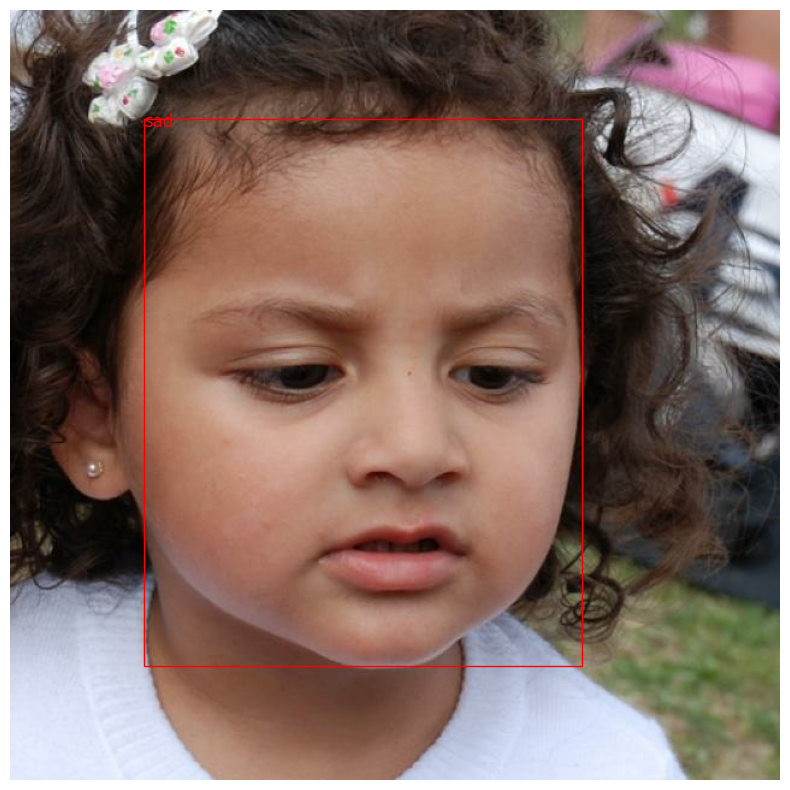

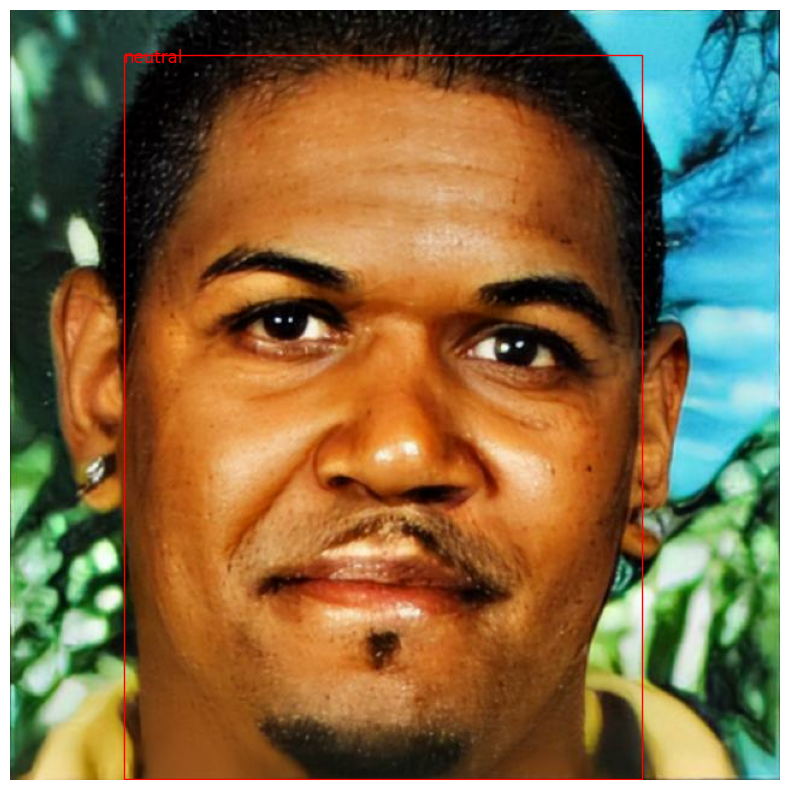

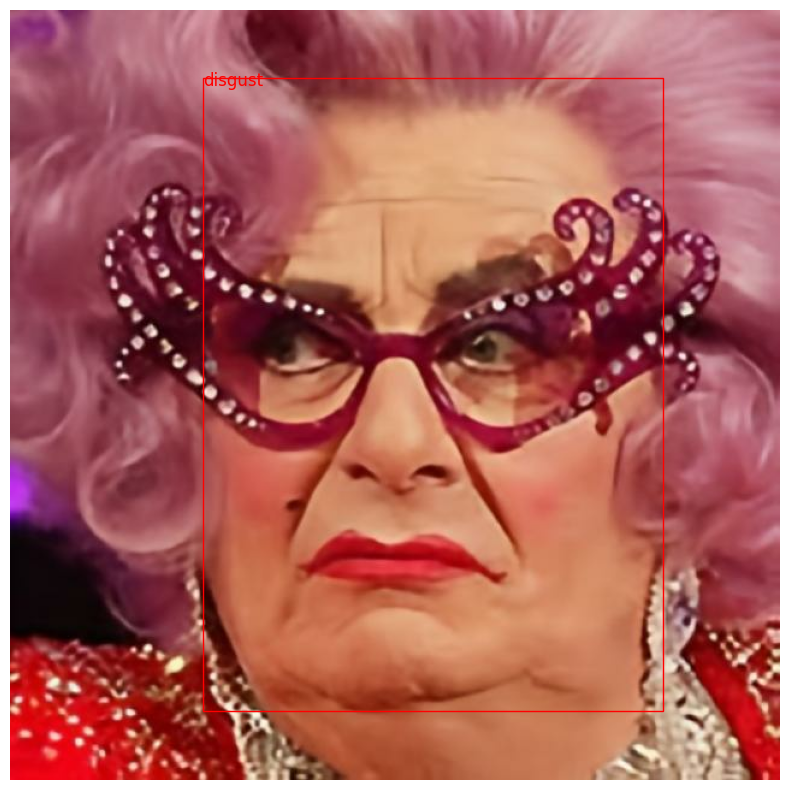

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_images_with_captions(dataset):
    for image_features in dataset:
        image_raw = image_features['image/encoded'].numpy()
        image = tf.image.decode_jpeg(image_raw)
        
        plt.figure(figsize=(10, 10))
        plt.imshow(image.numpy())
        
        # If the bounding box data exists
        if 'image/object/bbox/xmin' in image_features:
            xmin = tf.sparse.to_dense(image_features['image/object/bbox/xmin']).numpy()
            xmax = tf.sparse.to_dense(image_features['image/object/bbox/xmax']).numpy()
            ymin = tf.sparse.to_dense(image_features['image/object/bbox/ymin']).numpy()
            ymax = tf.sparse.to_dense(image_features['image/object/bbox/ymax']).numpy()
            classes_text = tf.sparse.to_dense(image_features['image/object/class/text'], default_value='').numpy()
            classes_text = [text.decode('utf-8') for text in classes_text]

            for i in range(len(xmin)):
                rect = patches.Rectangle((xmin[i]*image.shape[1], ymin[i]*image.shape[0]), 
                                         (xmax[i]-xmin[i])*image.shape[1], 
                                         (ymax[i]-ymin[i])*image.shape[0], 
                                         linewidth=1, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
                plt.gca().text(xmin[i]*image.shape[1], ymin[i]*image.shape[0] - 5, 
                               classes_text[i], color='red', fontsize=12, verticalalignment='top')

        plt.axis('off')
        plt.show()

# Example of using the display function with your parsed dataset
display_images_with_captions(dataset.take(3))


In [ ]:
_transform_module_file = '_transform_component.py'

In [ ]:
%%writefile {_transform_module_file}
import tensorflow_transform as tft
import tensorflow as tf

def preprocessing_fn(inputs):
    """Preprocess input columns into transformed columns."""
    outputs = inputs
    
    return outputs

Overwriting _transform_component.py


In [ ]:
transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))
context.run(transform, enable_cache=True)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying exporter_tf1_test.py -> build/lib
copying export_tflite_ssd_graph_lib.py -> build/lib
copying export_tflite_ssd_graph_lib_tf1_test.py -> build/lib
copying export_inference_graph.py -> build/lib
copying inputs_test.py -> build/lib
copying exporter.py -> build/lib
copying model_main_tf2.py -> build/lib
copying exporter_lib_tf2_test.py -> build/lib
copying inputs.py -> build/lib
copying model_lib_v2.py -> build/lib
copying eval_util.py -> build/lib
copying model_lib_tf1_test.py -> build/lib
copying model_tpu_main.py -> build/lib
copying eval_util_test.py -> build/lib
copying export_tflite_graph_tf2.py -> build/lib
copying export_tflite_graph_lib_tf2.py -> build/lib
copying model_hparams.py -> build/lib
copying exporter_lib_v2.py -> build/lib
copying exporter_main_v2.py -> build/lib
copying export_tflite_graph_lib_tf2_test.py -> build/lib
copying export_tflite_ssd_graph.py -> build/lib
copying _tra

/home/nightstalker/miniconda3/envs/tfx/lib/python3.9/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()


Processing /tmp/tfx-interactive-2024-05-12T12_47_30.457696-ip1zycrf/_wheels/tfx_user_code_Transform-0.0+b03d52c491af6e952d365543dd3aea7d305f9223be072306be260a07847e7dce-py3-none-any.whl
Processing /tmp/tfx-interactive-2024-05-12T12_47_30.457696-ip1zycrf/_wheels/tfx_user_code_Transform-0.0+b03d52c491af6e952d365543dd3aea7d305f9223be072306be260a07847e7dce-py3-none-any.whl
Processing /tmp/tfx-interactive-2024-05-12T12_47_30.457696-ip1zycrf/_wheels/tfx_user_code_Transform-0.0+b03d52c491af6e952d365543dd3aea7d305f9223be072306be260a07847e7dce-py3-none-any.whl
INFO:tensorflow:Assets written to: /tmp/tfx-interactive-2024-05-12T12_47_30.457696-ip1zycrf/Transform/transform_graph/5/.temp_path/tftransform_tmp/a2a46cfe328149b6b029469655856c83/assets
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False)
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None, _is_async=False))

## Train

In [ ]:
_trainer_module = 'trainer_component.py'

In [ ]:
%%writefile {_trainer_module}

from typing import Dict, List, Text

import os
import glob
from absl import logging

import datetime
import tensorflow as tf
import tensorflow_transform as tft

from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_transform import TFTransformOutput


pipeline_config_path = 'my_tfx_project/models/efficientdet_d1_coco17_tpu-32/pipeline.config'
model_dir = 'trainingTFX'
saved_model_dir = 'inference_graph'
model_save_path = 'inference_graphTFX'


def _get_tf_examples_serving_signature(model, tf_transform_output):
  """Returns a serving signature that accepts `tensorflow.Example`."""

  # We need to track the layers in the model in order to save it.
  # TODO(b/162357359): Revise once the bug is resolved.
  model.tft_layer_inference = tf_transform_output.transform_features_layer()

  @tf.function(input_signature=[
      tf.TensorSpec(shape=[None], dtype=tf.string, name='examples')
  ])
  def serve_tf_examples_fn(serialized_tf_example):
    """Returns the output to be used in the serving signature."""
    raw_feature_spec = tf_transform_output.raw_feature_spec()
    # Remove label feature since these will not be present at serving time.
    raw_feature_spec.pop(_LABEL_KEY)
    raw_features = tf.io.parse_example(serialized_tf_example, raw_feature_spec)
    transformed_features = model.tft_layer_inference(raw_features)
    logging.info('serve_transformed_features = %s', transformed_features)

    outputs = model(transformed_features)
    # TODO(b/154085620): Convert the predicted labels from the model using a
    # reverse-lookup (opposite of transform.py).
    return {'outputs': outputs}

  return serve_tf_examples_fn

def _get_transform_features_signature(model, tf_transform_output):
  """Returns a serving signature that applies tf.Transform to features."""

  # We need to track the layers in the model in order to save it.
  # TODO(b/162357359): Revise once the bug is resolved.
  model.tft_layer_eval = tf_transform_output.transform_features_layer()

  @tf.function(input_signature=[
      tf.TensorSpec(shape=[None], dtype=tf.string, name='examples')
  ])
  def transform_features_fn(serialized_tf_example):
    """Returns the transformed_features to be fed as input to evaluator."""
    raw_feature_spec = tf_transform_output.raw_feature_spec()
    raw_features = tf.io.parse_example(serialized_tf_example, raw_feature_spec)
    transformed_features = model.tft_layer_eval(raw_features)
    logging.info('eval_transformed_features = %s', transformed_features)
    return transformed_features

  return transform_features_fn

def export_serving_model(tf_transform_output, model, output_dir):
  """Exports a keras model for serving.
  Args:
    tf_transform_output: Wrapper around output of tf.Transform.
    model: A keras model to export for serving.
    output_dir: A directory where the model will be exported to.
  """
  # The layer has to be saved to the model for keras tracking purpases.
  model.tft_layer = tf_transform_output.transform_features_layer()

  signatures = {
      'serving_default':
          _get_tf_examples_serving_signature(model, tf_transform_output),
      'transform_features':
          _get_transform_features_signature(model, tf_transform_output),
  }
  tf.saved_model.save(model, model_save_path)

# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
    """Train the model based on given args.
    
    Args:
    fn_args: Holds args used to train the model as name/value pairs.
    """
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)
    # command_train = f"python model_main_tf2.py --pipeline_config_path={pipeline_config_path} --model_dir={model_dir} ----alsologtostderr"
    # os.system(command_train)
    # command_save = f"python exporter_main_v2.py --trained_checkpoint_dir={model_dir} --pipeline_config_path={pipeline_config_path} --output_directory {saved_model_dir}"
    # os.system(command_save)

    model_path = f'{saved_model_dir}/saved_model/'
    
    model = tf.saved_model.load(model_path)
    
    # Export the model.
    export_serving_model(tf_transform_output, model, fn_args.serving_model_dir)

Overwriting trainer_component.py


In [ ]:
trainer = tfx.components.Trainer(
    module_file=os.path.abspath(_trainer_module),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],)
context.run(trainer, enable_cache=True)

/home/nightstalker/miniconda3/envs/tfx/lib/python3.9/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying exporter_tf1_test.py -> build/lib
copying export_tflite_ssd_graph_lib.py -> build/lib
copying export_tflite_ssd_graph_lib_tf1_test.py -> build/lib
copying export_inference_graph.py -> build/lib
copying taxi_trainer.py -> build/lib
copying inputs_test.py -> build/lib
copying exporter.py -> build/lib
copying model_main_tf2.py -> build/lib
copying exporter_lib_tf2_test.py -> build/lib
copying inputs.py -> build/lib
copying trainer_component.py -> build/lib
copying model_lib_v2.py -> build/lib
copying eval_util.py -> build/lib
copying model_lib_tf1_test.py -> build/lib
copying model_tpu_main.py -> build/lib
copying eval_util_test.py -> build/lib
copying export_tflite_graph_tf2.py -> build/lib
copying export_tflite_graph_lib_tf2.py -> build/lib
copying model_hparams.py -> build/lib
copying exporter_lib_v2.py -> build/lib
copying exporter_main_v2.py -> build/lib
copying export_tflite_graph_lib_tf2_te

RuntimeError: run_fn failed to generate model.

In [ ]:
import tensorflow as tf
from object_detection.utils import label_map_util
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model = tf.keras.models.load_model('inference_graph/saved_model/')

ValueError: Unable to create a Keras model from SavedModel at inference_graph/saved_model/. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

In [ ]:
model = tf.saved_model.load('inference_graph/saved_model/')

In [ ]:
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7a18a36b2400>

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap('my_tfx_project/data/labelmap/labelmap.pbtxt',
                                                                    use_display_name=True)

In [ ]:
category_index

{1: {'id': 1, 'name': 'surprise'},
 2: {'id': 2, 'name': 'fear'},
 3: {'id': 3, 'name': 'anger'},
 4: {'id': 4, 'name': 'neutral'},
 5: {'id': 5, 'name': 'sad'},
 6: {'id': 6, 'name': 'contempt'},
 7: {'id': 7, 'name': 'disgust'},
 8: {'id': 8, 'name': 'happy'}}

In [ ]:
PATH = 'my_tfx_project/data/raw/train/'

IMAGE_PATHS = [os.path.join(PATH, name) for name in os.listdir(PATH) if name.endswith('.jpg')]

In [ ]:
IMAGE_PATHS

['my_tfx_project/data/raw/train/image0041591_jpg.rf.f194aba26e9249fc8a96b14f08083056.jpg',
 'my_tfx_project/data/raw/train/image0022223_jpg.rf.a7b230b30c8ed124dc1a3f28dad95601.jpg',
 'my_tfx_project/data/raw/train/image0036056_jpg.rf.b25cb6d9bd301165f14897c271872a33.jpg',
 'my_tfx_project/data/raw/train/image0042100_jpg.rf.f33f716b79e48c8df231138d864ab5a6.jpg',
 'my_tfx_project/data/raw/train/image0035929_jpg.rf.f0268934f9d88894fd746e193680462b.jpg',
 'my_tfx_project/data/raw/train/ffhq_2466_png.rf.b735423b97239381a5f560a86276479f.jpg',
 'my_tfx_project/data/raw/train/image0005353_jpg.rf.5ee1d3490c0cfc0c1b3792602f110df3.jpg',
 'my_tfx_project/data/raw/train/ffhq_994_png.rf.621ed0864a97f262bf00e0dfc9592c8e.jpg',
 'my_tfx_project/data/raw/train/image0021125_jpg.rf.4d731a9c5f2ceeb5c444bf5abe3fc8c0.jpg',
 'my_tfx_project/data/raw/train/image0038055_jpg.rf.9cfdff8e86f9da1118c2cbbdff68dca9.jpg',
 'my_tfx_project/data/raw/train/image0000399_jpg.rf.166bb191c53148c8280599e3398accae.jpg',
 'my_t

Running inference for my_tfx_project/data/raw/train/image0017464_jpg.rf.d2dcffcf8408be7c4d27f0ceeca1eecf.jpg... 

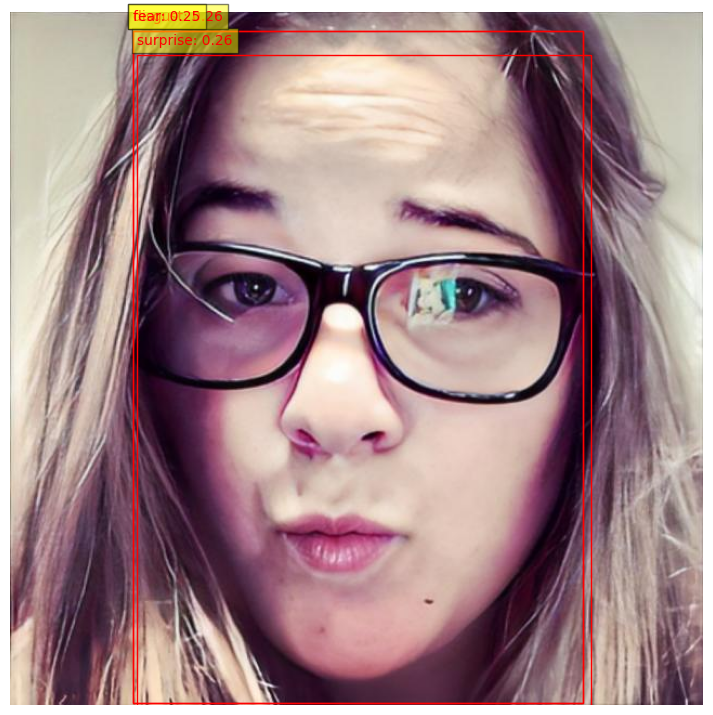

Running inference for my_tfx_project/data/raw/train/image0040187_jpg.rf.83d130bc75b30485c69a36b8aa818829.jpg... 

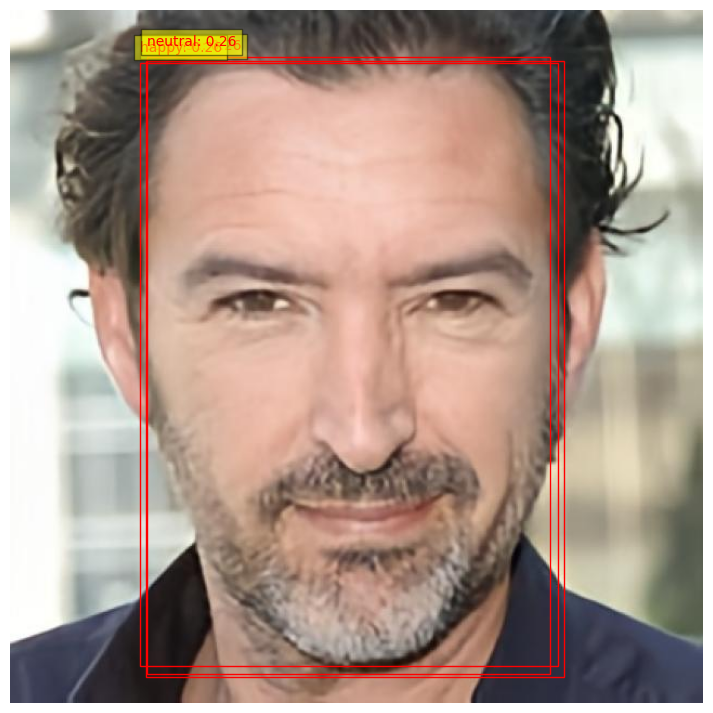

Running inference for my_tfx_project/data/raw/train/ffhq_5013_png.rf.0ab9d5f01b2a10bfc28181cad69aaba3.jpg... 

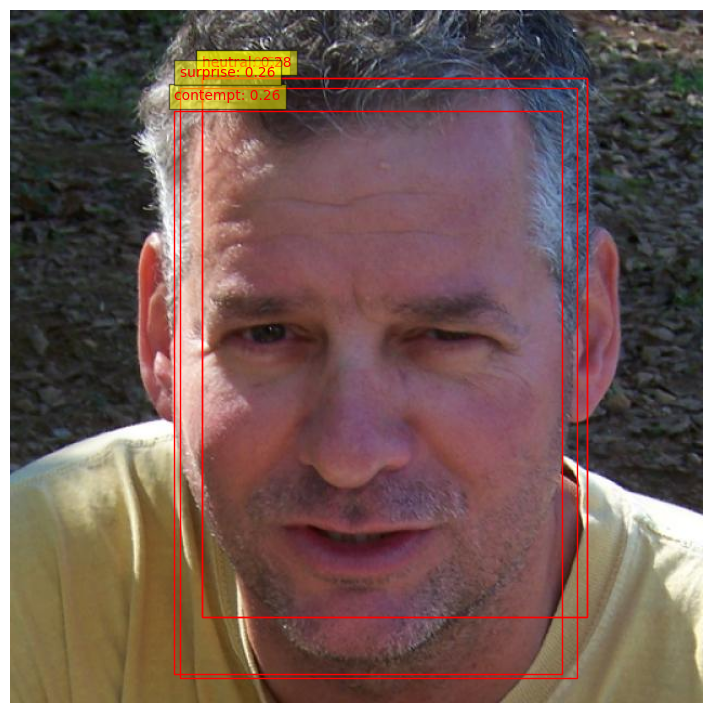

Running inference for my_tfx_project/data/raw/train/image0014263_jpg.rf.ba09ab0ab5176fa6c2e3372d0dc3bc3f.jpg... 

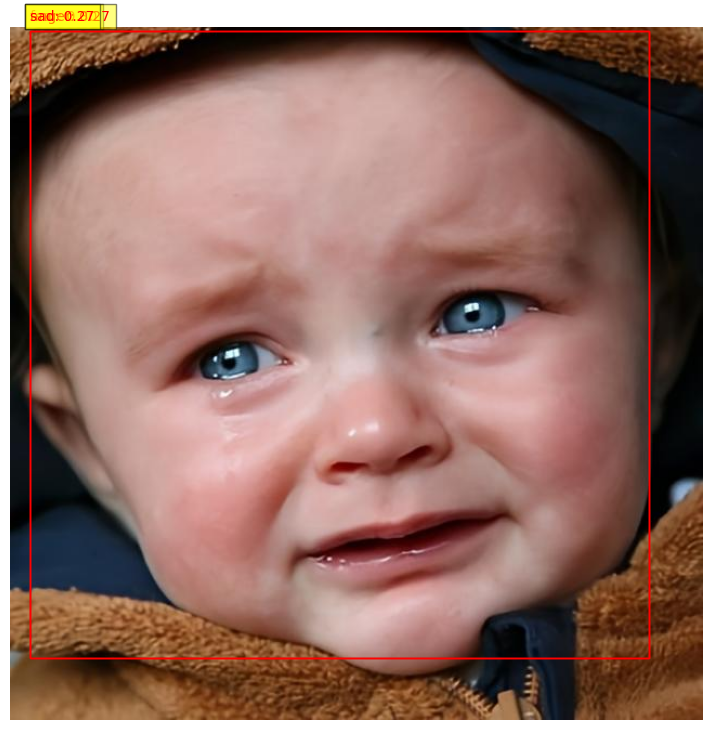

Running inference for my_tfx_project/data/raw/train/image0026162_jpg.rf.f88d1e78574b6bebd44c3ff3d1ca54f5.jpg... 

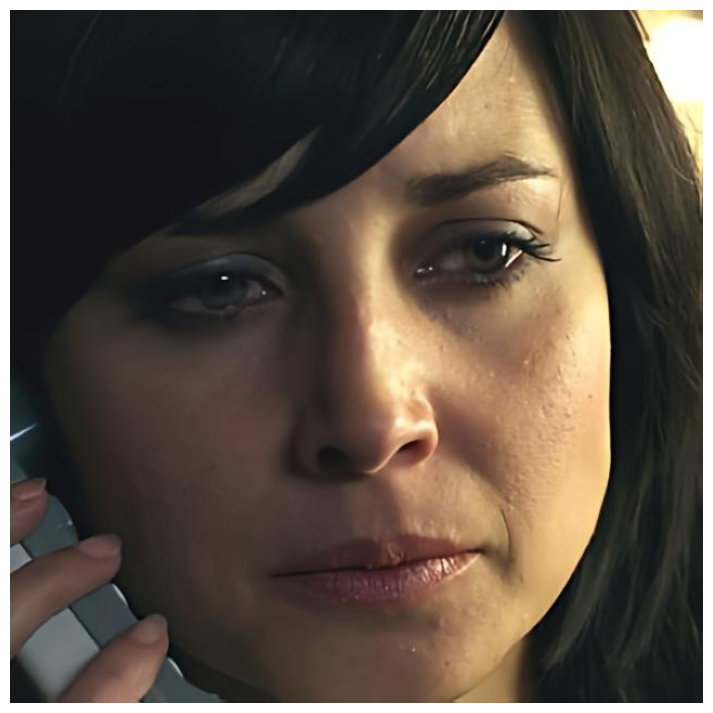

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def draw_boxes_on_image(image, boxes, classes, scores, category_index, threshold=0.3):
    """
    Draw bounding boxes and labels on the image.

    Args:
        image (numpy array): the image as a numpy array [H, W, 3]
        boxes (numpy array): the bounding boxes in normalized coordinates [N, 4]
        classes (numpy array): the class indices [N]
        scores (numpy array): the scores of each detection [N]
        category_index (dict): a dict containing category dictionaries for each class index
                               e.g., {1: {'id': 1, 'name': 'class1'}}
        threshold (float): score threshold for displaying bounding boxes.
    """
    # Set up the figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Draw each box
    for i, box in enumerate(boxes):
        if scores[i] < threshold:
            continue
        ymin, xmin, ymax, xmax = box
        label = category_index[classes[i]]['name']
        score = scores[i]

        # Convert to image coordinates
        xmin = xmin * image.shape[1]
        xmax = xmax * image.shape[1]
        ymin = ymin * image.shape[0]
        ymax = ymax * image.shape[0]

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add label
        ax.text(xmin, ymin - 10, f'{label}: {score:.2f}', color='red', fontsize=10, 
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')  # Turn off axis
    plt.show()

for image_path in IMAGE_PATHS[-20:-15]:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]


    # input_tensor = np.expand_dims(image_np, 0)
    detections = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()



    # Example usage
    draw_boxes_on_image(
        image_np,  # Loaded image as numpy array
        detections['detection_boxes'],  # Bounding box coordinates
        detections['detection_classes'],  # Class IDs for each box
        detections['detection_scores'],  # Scores for each box
        category_index,  # Category index dictionary
        threshold=0.25  # Minimum score threshold
    )


In [ ]:
!conda install aequitas

In [ ]:
from tfx import v1 as tfx
from tfx.dsl.component.experimental.decorators import component
from tfx.dsl.component.experimental.annotations import InputArtifact, OutputArtifact
import pandas as pd
from aequitas.group import Group
from aequitas.preprocessing import preprocess_input_df

@component
def BiasAuditComponent(
    examples: InputArtifact[tfx.types.standard_artifacts.Examples],
    model: InputArtifact[tfx.types.standard_artifacts.Model],
    output: OutputArtifact[tfx.types.standard_artifacts.Statistics],
):
    eval_data = pd.read_csv(examples.uri)

    eval_data['predictions'] = model.predict(eval_data[feature_columns])

    # Prepare data for Aequitas
    input_data = preprocess_input_df(eval_data)

    # Perform bias audit
    g = Group()
    xtab, _ = g.get_crosstabs(input_data)
    bias_report = g.get_disparity_predefined_groups(xtab, original_df=input_data)

    # Save bias report
    bias_report.to_csv(output.uri)

# Integrate this component into your pipeline
bias_audit = BiasAuditComponent(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    output=output_artifact,
)

In [ ]:
!conda install shap

In [ ]:
from tfx import v1 as tfx
from tfx.dsl.component.experimental.decorators import component
from tfx.dsl.component.experimental.annotations import InputArtifact, OutputArtifact
import shap
import tensorflow as tf

@component
def ShapExplainabilityComponent(
    examples: InputArtifact[tfx.types.standard_artifacts.Examples],
    model: InputArtifact[tfx.types.standard_artifacts.Model],
    output: OutputArtifact[tfx.types.standard_artifacts.Statistics],
):
    # Load evaluation data
    eval_data = "../data/processed/"

    # Load model
    model = tf.keras.models.load_model(model.uri)

    # Create SHAP explainer
    explainer = shap.KernelExplainer(model.predict, eval_data)

    # Calculate SHAP values
    shap_values = explainer.shap_values(eval_data)

    # Plot SHAP values
    shap.summary_plot(shap_values, eval_data, show=False)

    # Save the plot
    plt.savefig(output.uri)

# Integrate this component into your pipeline
shap_explainability = ShapExplainabilityComponent(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    output=output_artifact, 
)

In [ ]:
example_gen = tfx.components.ImportExampleGen(input_base="../data/processed/")
trainer = tfx.components.Trainer(module_file="../data/raw/train/_annotations.csv")
bias_audit = BiasAuditComponent(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    output=tfx.dsl.components.OutputArtifact(tfx.types.standard_artifacts.Statistics),
)
shap_explainability = ShapExplainabilityComponent(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    output=tfx.dsl.components.OutputArtifact(tfx.types.standard_artifacts.Statistics),
)

# pipeline
pipeline = tfx.dsl.Pipeline(
    pipeline_name="my_pipeline",
    pipeline_root=PIPELINE_ROOT,
    components=[
        example_gen,
        trainer,
        bias_audit,
        shap_explainability,
    ],
    enable_cache=True,
    metadata_connection_config=tfx.orchestration.metadata.sqlite_metadata_connection_config(METADATA_PATH),
)